In [1]:
import json
import numpy as np
import os
import pandas as pd

In [22]:
# Load GPT generated data
def json_to_df(path) :
    df = pd.DataFrame()
    with open(path, 'r') as f:
        for x in f:
            item = json.loads(x)
            df = df.append(item, ignore_index = True)
    return df
     
path = '/Users/kipnisal/Data/AuthorshipAI/GPT2/large-762M-k40.test.jsonl'
data_GPT = json_to_df(path)

data_GPT = data_GPT.rename(columns = {'article' : 'text', 'title' : 'doc_id', 'label' : 'author'})
data_GPT = data_GPT.rename( columns = {'id' : 'doc_id', 'length' : 'no_words'})
data_GPT.loc[:,'author'] = 'GPT2'

In [2]:
# Load Grover generated data
def json_to_df(path) :
    df = pd.DataFrame()
    with open(path, 'r') as f:
        for x in f:
            item = json.loads(x)
            df = df.append(item, ignore_index = True)
    return df
     
path = 'generator=mega_dataset=p0.94.jsonl'
data_Grover = json_to_df(path)

In [7]:
data_Grover = data_Grover[data_Grover.label == 'machine']
data_Grover = data_Grover.rename(columns = {'article' : 'text', 'title' : 'doc_id', 'label' : 'author'})
data_Grover.loc[:,'author'] = 'Grover'

In [ ]:
import sys
sys.path.append('/Users/kipnisal/Documents/Authorship/')
from text_processing import *

data_all = data_all.rename(columns = {'article' : 'text', 'title' : 'doc_id', 'label' : 'author'})
data_all.text = data_all.text.astype(str).apply(lambda x : preprocess_text(x, stem = True,
                                                            #clean_names = True,
                                                            #clean_html_tags = True,
                                                            #clean_digits = True
                                                           ))
data_all.to_csv('~/Data/Gover_challenge_stemed.csv')

<H1>Classify Samples</H1>

In [10]:
%load_ext autoreload
import os
import re
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('/Users/kipnisal/Documents/Authorship/')

from AuthAttLib import *
from visualize_HC_scores import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def merge_consecutive(ds, n = 1) :
    # use this function to increase size of documents while maintaining
    # separation to authors
    # 
    # Output is shuffled
    ds_all = pd.DataFrame()
    for g in ds.groupby('author') :
        merged_text = g[1].groupby(np.arange(len(g[1]))//n).text.agg(sum)
        df = g[1].iloc[np.arange(0,len(g[1]),n)].reset_index()
        df.text = merged_text
        ds_all = ds_all.append(df)

    ds_all = ds_all.reset_index()
    ds_all.loc[:,'no_words'] = ds_all.text.astype(str).apply(lambda x : len(x.split()))
    
    ds_all = ds_all.reindex(np.random.permutation(ds_all.index))
    return ds_all

<H3>Filter and re-classify data</H3>

In [44]:
data_all = pd.concat([data_Grover.filter(['doc_id','author','text']),
                      data_GPT.filter(['doc_id','author','text'])
                    ], sort = False).reset_index()

#trim 1
data = data_all.groupby('author').head(500)

#shuffle
data = data.reindex(np.random.permutation(data.index))

#trim 2
data_train = data.head(200)
data_test = data.tail(100)


In [45]:
#load preset vocabulary
STEM = False
from text_processing import *
VOCAB_SIZE = 1000
vocab5000 = pd.read_csv('~/Data/5000 most common english words.csv')
vocab = list(pd.unique(vocab5000[vocab5000.Rank <= VOCAB_SIZE].Word))
if STEM :
    vocab = stem_text(" ".join(vocab)).split()
    vocab = list(set(vocab)) # to remove dublicate terms

In [46]:
words_to_ignore = ['ms','mr' ,'dr', 'miss', 'york', 'courtesi', 'trump', 'million',
                  'michael','john','donald', 'email', 'meghan', 'bbc', 'nigeria', 'kim',
                  'buttigieg', 'cleveland', 'gov', 'saturday', 'sunday', 'sp', 'amazon',
                  'jone', 'la', 'barr','cathedr', 'duke', 'airlin', 'doe', 'jackson',
                  'africa','alberta','iran', 'nfl', 'andrew', 'davi', 'de', 'en', 'khan',
                  'dame','chicago', 'florida']

In [57]:
#train model
ds = data_train
model = AuthorshipAttributionMulti(ds,
                               vocab = vocab,
                          #    vocab_size = 500,
                          #    ngram_range = (1,1),
                          #  words_to_ignore = words_to_ignore,
                              stbl = True)

df0 = model.internal_stats_corpus()
df0

	 Creating author-model for Grover using 901 features
		found 101 documents and 26632 relevant tokens
	 Creating author-model for GPT2 using 901 features


  0%|          | 0/2 [00:00<?, ?it/s]

		found 99 documents and 29639 relevant tokens


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


,HC,author,chisq,chisq_pval,cosine,feat,no_docs (author),no_docs (wrt_author),no_tokens (author),wrt_author
0,14.695671,Grover,2022.266596,2.282450e-213,0.008153,"[be, and, in, to, have, that, you, he, do, say...",101.0,99.0,26632.0,GPT2


In [30]:
pd.DataFrame(df0.feat.values[0])

,0
0,you
1,this
2,we
3,his
4,she
5,their
6,can
7,if
8,her
9,year


In [58]:
ds_test = data_test.head(50)
df_test = model.stats_list(ds_test)

100%|██████████| 2/2 [00:38<00:00, 19.38s/it]


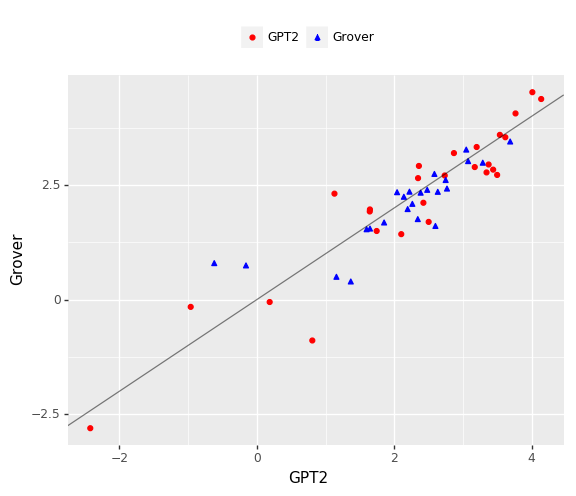

<ggplot: (304460499)>


In [59]:
p = plot_author_pair(df_test, value = 'HC', title = '')
print(p)

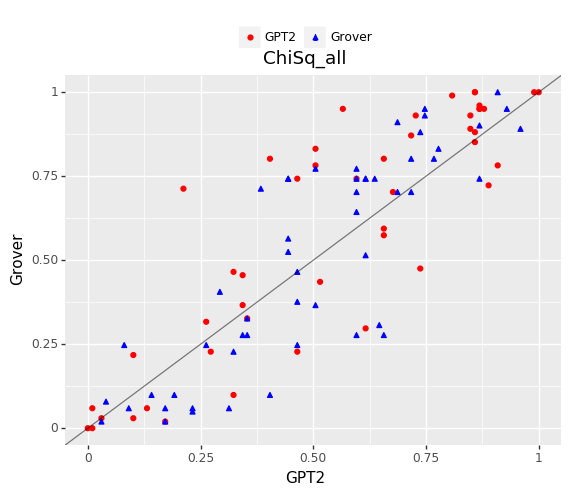

<ggplot: (304795298)>


In [55]:
title = "ChiSq_all"
p = plot_author_pair(df_test, value = 'rank', title = title)
#p.save(title + '.png')
print(p)

In [366]:
def plot_author_pair(df, value = 'HC', wrt_author = [],
                     show_legend=True, title=""):
    
    df1 = df.filter(['doc_id', 'author', 'wrt_author', 'type', value])\
            .pivot_table(index = ['doc_id','author','type'],
                         columns = 'wrt_author',
                         values = [value])[value].reset_index()

    lo_authors = pd.unique(df1.author)
    no_authors = len(lo_authors)
    
    if no_authors < 2 :
        raise ValueError
    
    if wrt_author == [] :
        wrt_author = (lo_authors[0],lo_authors[1])

    if (no_authors == 2):
        color_map = {wrt_author[0]: "red", wrt_author[1]: "blue"}
    else:
        color_map = LIST_OF_COLORS

    df1.loc[:, 'x'] = df1.loc[:, wrt_author[0]].astype('float')
    df1.loc[:, 'y'] = df1.loc[:, wrt_author[1]].astype('float')
    p = (
        ggplot(aes(x='x', y='y', color='author', shape = 'type'), data=df1) +
        geom_point(show_legend=show_legend) + geom_abline(alpha=0.5) +
        # geom_text(aes(label = 'doc_id', check_overlap = True)) +
        xlab(wrt_author[0]) + ylab(wrt_author[1]) +
        scale_color_manual(values=color_map) +  #+ xlim(0,35) + ylim(0,35)
        ggtitle(title) #+ xlim(-5,10) + ylim(-5,10)
        + theme(legend_title=element_blank(), legend_position='top'))
    return p

In [10]:
#try on test set 
ds_test_sm = ds_test_db.head(10)

acc = 0
no_sm = 0
for r in tqdm(ds_test_sm.iterrows()) :
    res = model.predict(r[1].text, method='rank')
    no_sm += 1
    if r[1].author == res[0] :
        acc += 1
    print("accuracy = {}".format(acc / no_sm))

1it [00:00,  1.86it/s]

accuracy = 0.0


2it [00:01,  1.83it/s]

accuracy = 0.5


3it [00:01,  1.81it/s]

accuracy = 0.6666666666666666


4it [00:02,  1.85it/s]

accuracy = 0.75


5it [00:02,  1.84it/s]

accuracy = 0.8


6it [00:03,  1.91it/s]

accuracy = 0.6666666666666666


7it [00:03,  1.96it/s]

accuracy = 0.5714285714285714


8it [00:04,  1.89it/s]

accuracy = 0.625


9it [00:04,  1.90it/s]

accuracy = 0.5555555555555556


10it [00:05,  1.80it/s]

accuracy = 0.6


In [11]:
# evaluate on test set
ds_test_sm = ds_test_db.head(10)
df_test = pd.DataFrame()
for r in ds_test_sm.iterrows() :
    df1 = model.predict_stats(r[1].text)
    df1.loc[:,'author'] = r[1].author
    df1.loc[:,'doc_id'] = r[1].doc_id
    df_test = df_test.append(df1)


In [15]:
ds_test_sm = ds_test_db.head(50)
df_test = model.stats_list(ds_test_sm)

100%|██████████| 2/2 [00:25<00:00, 13.03s/it]


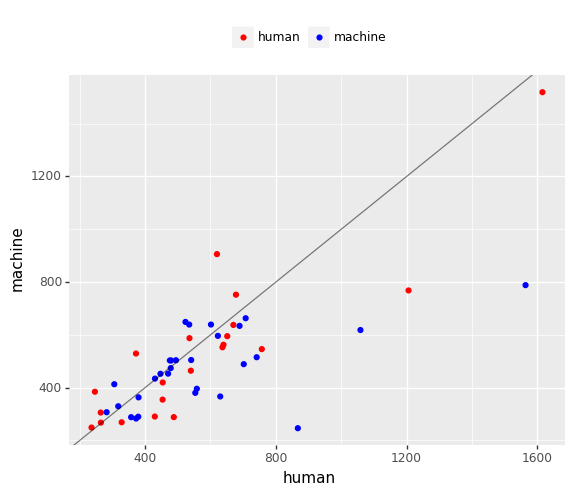

<ggplot: (307352289)>

In [16]:
def plot_author_pair(df, value = 'HC', wrt_author = [],
                     show_legend=True, title=""):
    
    df1 = df.filter(['doc_id', 'author', 'wrt_author', value])\
            .pivot_table(index = ['doc_id','author'],
                         columns = 'wrt_author',
                         values = [value])[value].reset_index()

    lo_authors = pd.unique(df1.author)
    no_authors = len(lo_authors)
    
    if no_authors < 2 :
        raise ValueError
    
    if wrt_author == [] :
        wrt_author = (lo_authors[0],lo_authors[1])

    if (no_authors == 2):
        color_map = {wrt_author[0]: "red", wrt_author[1]: "blue"}
    else:
        color_map = LIST_OF_COLORS

    df1.loc[:, 'x'] = df1.loc[:, wrt_author[0]].astype('float')
    df1.loc[:, 'y'] = df1.loc[:, wrt_author[1]].astype('float')
    p = (
        ggplot(aes(x='x', y='y', color='author'), data=df1) +
        geom_point(show_legend=show_legend) + geom_abline(alpha=0.5) +
        # geom_text(aes(label = 'doc_id', check_overlap = True)) +
        xlab(wrt_author[0]) + ylab(wrt_author[1]) +
        scale_color_manual(values=color_map) +  #+ xlim(0,35) + ylim(0,35)
        ggtitle(title) #+ xlim(0,5000) + ylim(0,5000)
        + theme(legend_title=element_blank(), legend_position='top'))
    return p

plot_author_pair(df_test, value = 'chisq')

100%|██████████| 2/2 [00:50<00:00, 25.48s/it]


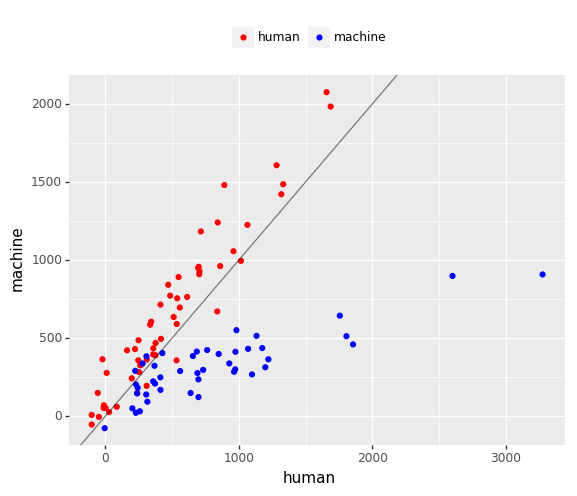

<ggplot: (-9223372036544183236)>

In [20]:
df1 = model.internal_stats()
plot_author_pair(df1, value = 'chisq')

100%|██████████| 2/2 [00:49<00:00, 24.46s/it]


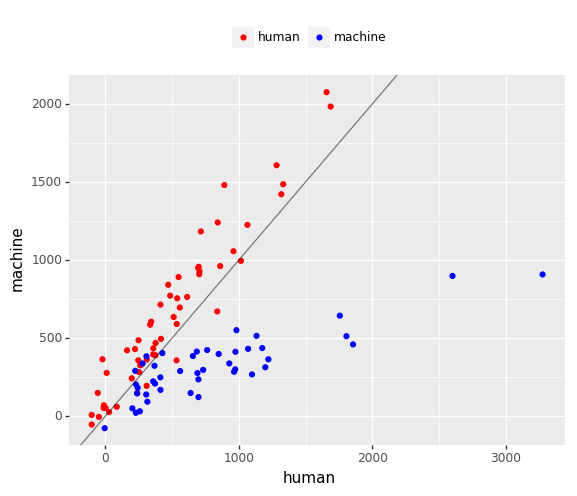

<ggplot: (308156522)>